## To do 

Sort order Year, month ,day graphs 
create pie charts of sentiment breakdown(neg,pos, neutral)


# Project Summary 
To identify and explore the sentiment of tweets referencing the top 5 banks in South Africa, namely:
1. Standard Bank 
1. First National Bank (FNB) 
1. Capitec Bnak 
1. Nedbank
1. ABSA Bank 



#### Previous Methodology (cleaning and Textblob)
* Vectorize tweets using TfidfVectorize
* Clean tweets using regex
* Additional features (length) 

### Current methodology 
* Apply [custom created pipeline (tfidf,xgboost) model](https://www.kaggle.com/slythe/twitter-sentiment-analysis-custom-model/) to predict Tweet Sentiment.
* Explore sentiment results using matplotlib and Seaborn

[Data](../input/twitter-scrape-of-the-top-5-banks-in-south-africa) obtained by Twint Scraping (POC notebook can be found [here](https://www.kaggle.com/slythe/sentiment-analysis-with-twint-textblob-poc) )

#### Project 2:
Compare results to the Customer Satifaction Index (CSI) and determine if the CSI is a correct reflection of the consumer sentiment

### Twint  guide

<b>My reference guide: </b>
https://github.com/Slyth3/Twitter_NLP/blob/main/Quick%20Twint%20Code.txt

<b> Official Github: </b>
https://github.com/twintproject/twint

In [73]:
import twint
import pandas as pd
import nest_asyncio             
import matplotlib.pyplot as plt

#Reading data and models
import glob                     
import os
import pickle

import numpy as np
import datetime as dt
import seaborn as sns

#cleaning
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords             

# Sentiment Analysis
from textblob import TextBlob

#word cloud
from wordcloud import WordCloud

# Get data

In [74]:
tweets_df= pd.concat(map(pd.read_pickle, glob.glob(os.path.join('', r"C:/Users/andre/OneDrive/Desktop/Personal/Data Science/Projects/Bank_NLP_Twitter/Bank_NLP_Twitter_Full/Output/OneString/merged_files/full/full*.pickle"))))
#tweets_df= pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../input/twitter-scrape-of-the-top-5-banks-in-south-africa/full*.csv"))))

In [75]:
tweets_df.shape

(1085729, 42)

In [76]:
tweets_df = tweets_df.drop(['created_at', 'user_id_str', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet','nreplies', 'nretweets', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],axis = 1)

In [77]:
tweets_df.head(2)

,id,conversation_id,date,timezone,place,tweet,language,hashtags,cashtags,user_id,username,name,day,hour,nlikes,search,cleaned_tweet,polarity,subjectivity,Sentiment
0,1123346313108754438,1123346313108754438,2019-04-30 22:00:06,+0000,,ABSA Co-branded Non-reloadable Prepaid Cards i...,en,[prepaidcreditcard],[],3286904341,saprepaidcard,saprepaidcard,2,22,0,"FNBSA OR (StandardBankZA OR ""Standard Bank"" OR...",absa cobranded nonreloadable prepaid cards is ...,0.433333,0.833333,Positive
1,1123345721715982342,1123345721715982342,2019-04-30 21:57:45,+0000,,Protecting children in school from violence an...,en,[],[],262372833,skinspafan,william seidel,2,21,0,"FNBSA OR (StandardBankZA OR ""Standard Bank"" OR...",protecting children in school from violence an...,0.000000,0.150000,Neutral


#### Language removal 

Although the language tag doesnt seem to get it right 100% of the time, we will drop these rows that arent english but keep undefined:
* und = undefined --- this will also include tweets with only hashtags so we will keep this
* en = english 

In [78]:
tweets_df["language"].unique()

array(['en', 'und'], dtype=object)

In [79]:
# remove all rows where language is not english or undefined
tweets_df = tweets_df[tweets_df["language"].isin([ 'und', 'en'])]

### Remove unnecessary rows 
* Remove tweets from Bank owned accounts i.e. FNBSA
* Remove duplicates where tweet, bank and date are the same 
* Reindex dataframe

In [80]:
# remove rows where username is in bank_search
tweets_df = tweets_df[ ~tweets_df["username"].str.lower().str.contains('fnb|standardbank|nedbank|absa|capitec',regex = True)]

In [81]:
#Drop duplicated tweets 
tweets_df = tweets_df.drop_duplicates(subset=['date',"tweet"],keep="first")

In [82]:
# reset the index for visualisation later
tweets_df.reset_index(inplace=True, drop = True )

In [83]:
tweets_df.shape

(1085352, 20)

#### Set index

In [84]:
tweets_df["date"] = pd.to_datetime(tweets_df["date"])

#set index = date so as to create rolling mean 
tweets_df = tweets_df.sort_values("date").set_index("date")

# Prediction

In [181]:
def Sentiment(val):
    if val == -1:
        return "Negative"
    elif val == 0:
        return "Neutral"
    elif val == 1:
        return "Postive"
    else:
        return "Other"

In [199]:
def proba(val):
    return pipe.predict_proba([val])[0]

In [182]:
def weighted_val(val):
    proba = list( pipe.predict_proba(np.array([val])) )[0]
    return proba, (proba[0]*-1 +proba[1]*0+proba[2]*1)

In [175]:
file = r"C:\Users\andre\OneDrive\Desktop\Personal\Data Science\Projects\Bank_NLP_Twitter\Bank_NLP_Twitter_Custom_Model\pipemodel_model.pickle"
pipe = pickle.load(open(file, 'rb'))

In [201]:
tweets_df["sentiment2"] = pipe.predict(tweets_df["cleaned_tweet"])
tweets_df["sentiment2"] = tweets_df["sentiment2"].apply(Sentiment)

In [200]:
tweets_df["proba"] = tweets_df["cleaned_tweet"].apply(proba)

KeyboardInterrupt: 

In [ ]:
#Final_df["proba"],Final_df["polarity2"]= zip(*Final_df["cleaned_tweet"].map(weighted_val))

In [ ]:
Final_df.head()

### set Bank column 

In [85]:
tweets_df["Bank"] = ""

In [86]:
def create_bank_col(df):
    #print (df[1]) 
    bank = df[1]
    if "fnb" in df[0].lower():
        bank =  bank+"FNB;"
    if "nedbank" in df[0].lower():
        bank =  bank+"Nedbank;"
    if "absa" in df[0].lower():
        bank =  bank+"ABSA;"
    if "standard" in df[0].lower():
        bank =  bank+"Standard;"
    if "capitec" in df[0].lower():
        bank =  bank+"Capitec;"
    return bank 

In [87]:
tweets_df["Bank"] = tweets_df[["tweet","Bank"]].apply(create_bank_col, axis =1 )

#### Create seperate dataframes

In [88]:
# stop this warning as the chaining works as intended
pd.options.mode.chained_assignment = None 

In [89]:
#Create bank Dataframes 
Standard_df = tweets_df[tweets_df["Bank"].str.contains("Standard")]
Standard_df["Bank"]= "Standard"

FNB_df = tweets_df[tweets_df["Bank"].str.contains("FNB")]
FNB_df["Bank"]= "FNB"

Nedbank_df = tweets_df[tweets_df["Bank"].str.contains("Nedbank")]
Nedbank_df["Bank"]= "Nedbank"

ABSA_df = tweets_df[tweets_df["Bank"].str.contains("ABSA")]
ABSA_df["Bank"]= "ABSA"

Cap_df = tweets_df[tweets_df["Bank"].str.contains("Capitec")]
Cap_df["Bank"]= "Capitec"

In [90]:
Final_df = pd.concat([ABSA_df,Standard_df,Nedbank_df,ABSA_df,Cap_df, FNB_df ], axis =0)

## Analysis and visualisation

In [ ]:
#install additional libraries for visualisation 
from collections import Counter

import cufflinks as cf
from plotly.offline import init_notebook_mode #, plot, iplot, download_plotlyjs
init_notebook_mode(connected = True)
cf.go_offline()

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [159]:
# Set Pallette 
sns.set_theme()
pal = {"FNB":'c', "Standard":"b","ABSA":"r","Nedbank":"g","Capitec":"grey"}

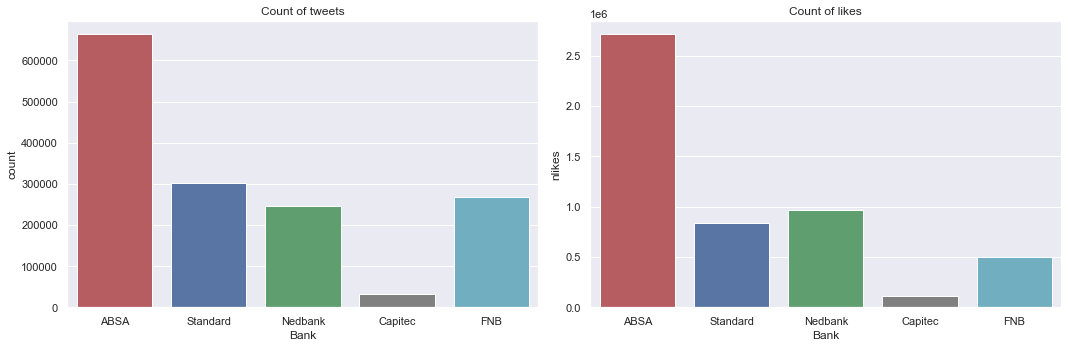

In [160]:
fig, ax = plt.subplots(1,2, figsize= (15,5))

sns.countplot(ax = ax[0], x= Final_df["Bank"], palette= pal)
ax[0].set_title("Count of tweets")

sns.barplot(data =Final_df, x = "Bank" ,y = "nlikes",estimator=np.sum,ci=None, palette=pal)
ax[1].set_title("Count of likes")

plt.tight_layout()
plt.show()

Bank,ABSA,Capitec,FNB,Nedbank,Standard
tweet,663220,31874,269103,245551,302058


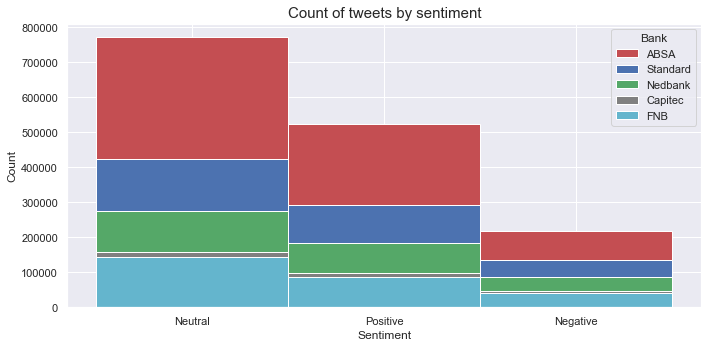

In [161]:
display(Final_df[["tweet","Bank"]].groupby(["Bank"]).count().transpose())

plt.figure(figsize=(10,5))
sns.histplot(Final_df, x="Sentiment", hue="Bank", palette= pal,multiple="stack", alpha = 1)
plt.title("Count of tweets by sentiment",fontsize =15)

plt.tight_layout()
plt.show()

Bank,ABSA,Capitec,FNB,Nedbank,Standard
tweet,663220,31874,269103,245551,302058


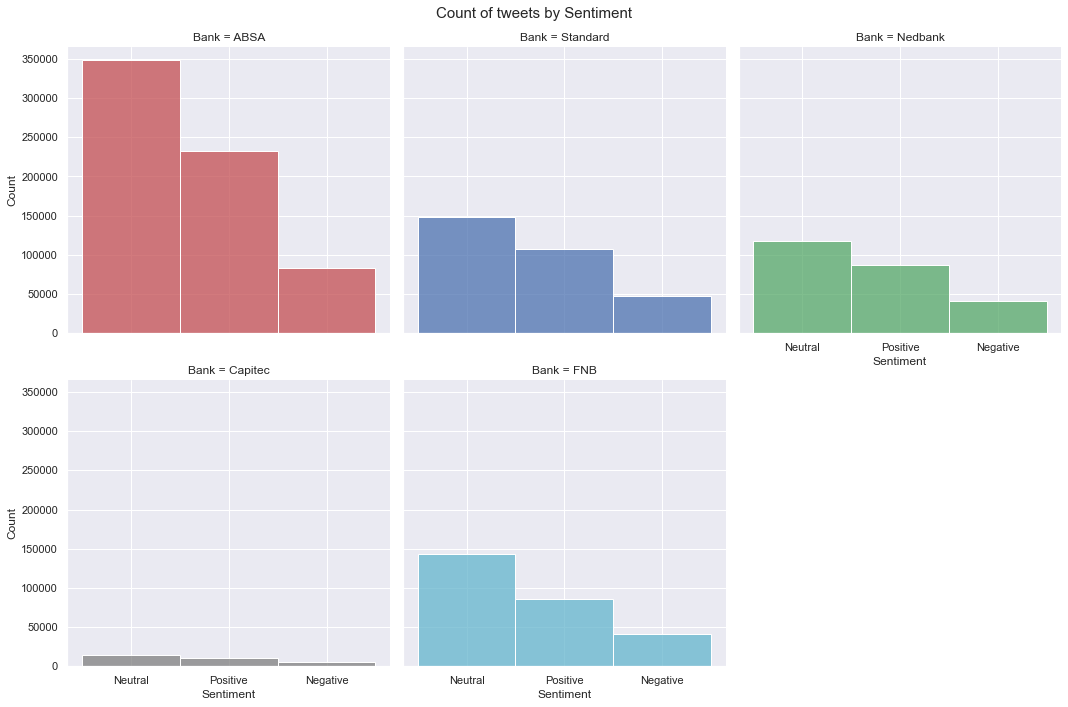

In [162]:
display(Final_df[["tweet","Bank"]].groupby(["Bank"]).count().transpose())

fig1 = sns.displot(Final_df, x="Sentiment", col="Bank",col_wrap= 3, hue="Bank", legend=False, palette= pal)
fig1.fig.suptitle("Count of tweets by Sentiment",fontsize =15)

plt.tight_layout()
plt.show()

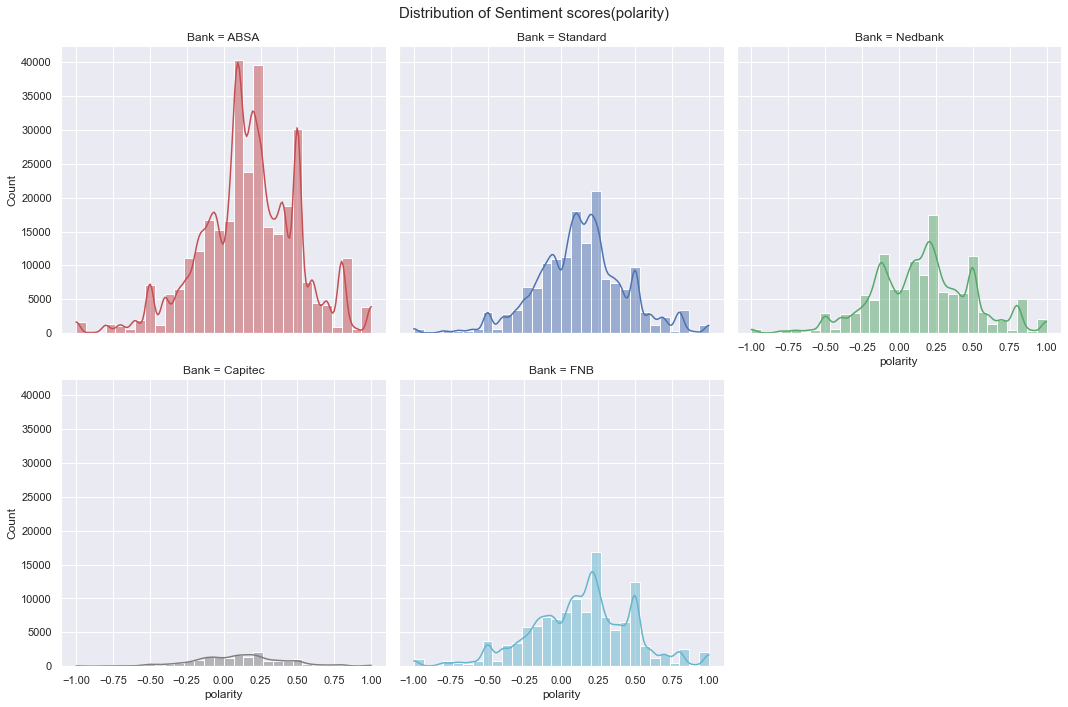

In [163]:
fig1 = sns.displot(data = Final_df[~(Final_df['polarity']==0)], x="polarity",
                   col="Bank",
                   col_wrap= 3, 
                   hue="Bank", 
                   legend=False, 
                   palette= pal,
                   kde = True,
                   bins =30)
fig1.fig.suptitle("Distribution of Sentiment scores(polarity)",fontsize =15 )

plt.tight_layout()
plt.show()

# Hashtag analysis 

In [164]:
#get all hashtags as list
def hashlist(df):
    hashlist = []
    for i in df['hashtags']:
        #use ast.literal if you are importing CSV files otherwise just use 'i'
        hashlist.extend(i)
    return hashlist

In [165]:
#Create hashtag dataframes
hash_Absa= pd.DataFrame(Counter(hashlist(ABSA_df)).items()).sort_values(1,ascending=False)
hash_NedBank= pd.DataFrame(Counter(hashlist(Nedbank_df)).items()).sort_values(1,ascending=False)
hash_StdBank= pd.DataFrame(Counter(hashlist(Standard_df)).items()).sort_values(1,ascending=False)
hash_FNB= pd.DataFrame(Counter(hashlist(FNB_df)).items()).sort_values(1,ascending=False)
hash_Cap= pd.DataFrame(Counter(hashlist(Cap_df)).items()).sort_values(1,ascending=False)

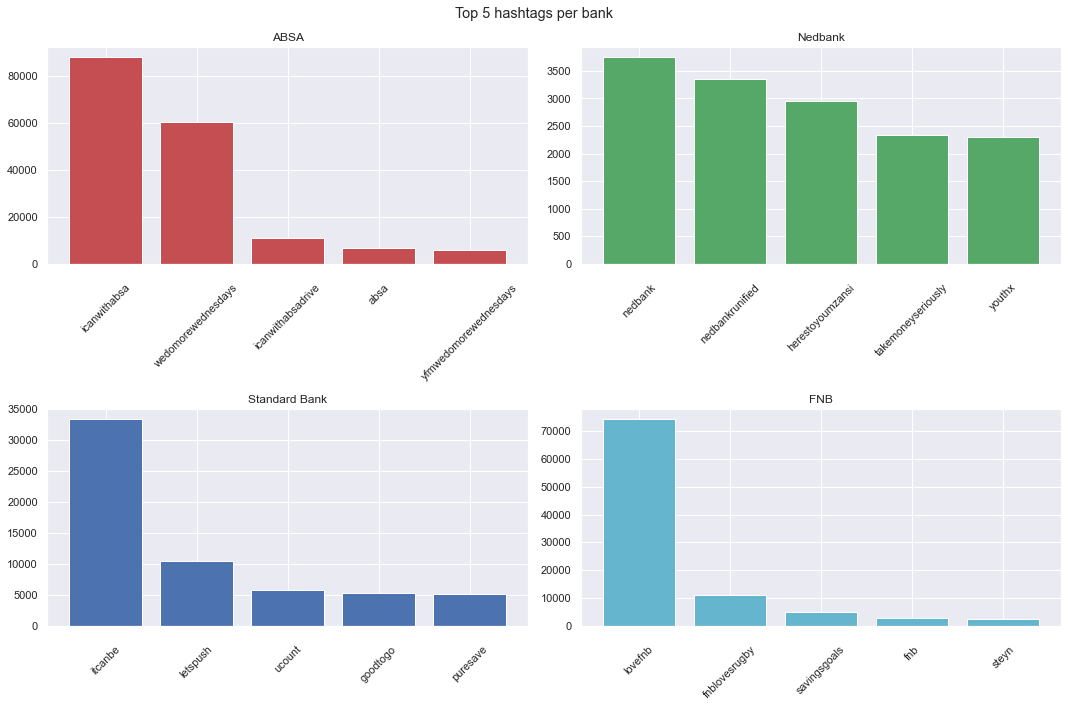

In [166]:
fig, ax = plt.subplots(2, 2,figsize=(15, 10))

plt.suptitle("Top 5 hashtags per bank")

# ABSA
ax[0,0].bar(hash_Absa[0].head(), hash_Absa[1].head(), color = "r")
ax[0,0].set_title("ABSA")
ax[0,0].xaxis.set_tick_params(rotation=45, size = 15)

ax[0,1].bar(hash_NedBank[0].head(), hash_NedBank[1].head(), color = "g")
ax[0,1].set_title("Nedbank")
ax[0,1].xaxis.set_tick_params(rotation=45, size = 15)

ax[1,0].bar(hash_StdBank[0].head(), hash_StdBank[1].head(), color = "b")
ax[1,0].set_title("Standard Bank")
ax[1,0].xaxis.set_tick_params(rotation=45, size = 15)

ax[1,1].bar(hash_FNB[0].head(), hash_FNB[1].head(), color = "c")
ax[1,1].set_title("FNB")
ax[1,1].xaxis.set_tick_params(rotation=45, size = 15)

plt.tight_layout()
plt.show()

# Word Cloud

In [167]:
tweetString_a = " ".join(list(ABSA_df["cleaned_tweet"])).lower()
tweetString_n = " ".join(list(Nedbank_df["cleaned_tweet"])).lower()
tweetString_s = " ".join(list(Standard_df["cleaned_tweet"])).lower()
tweetString_f = " ".join(list(FNB_df["cleaned_tweet"])).lower()

In [168]:
#remove Bank name and set wordcloud

tweetString_a = re.sub(r"absa|bank","",tweetString_a)
wordcloud_a = WordCloud(
                background_color ='white', 
                min_font_size = 5).generate(tweetString_a)

tweetString_n = re.sub(r"NedBankSA|Nedbank|nedbank|bank","",tweetString_n)   
wordcloud_n = WordCloud( 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_n)

tweetString_s = re.sub(r"standardbankza|standard bank|bank","",tweetString_s)     
wordcloud_s = WordCloud( 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_s)

tweetString_f = re.sub(r"FNB|fnb|bank","",tweetString_f)
wordcloud_f = WordCloud( 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_f)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(14, 8),sharey=True)

ax[0,0].imshow(wordcloud_s)
ax[0,1].imshow(wordcloud_f)
ax[1,0].imshow(wordcloud_n)
ax[1,1].imshow(wordcloud_a)

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("StandardBank")
ax[0,1].set_title("FNB")
ax[1,0].set_title("Nedbank")
ax[1,1].set_title("ABSA")

plt.tight_layout() 
plt.show()

In [ ]:
# Overall mean sentiment by bank
plt.figure(figsize=(10,5))
plt.title("Overall mean Sentiment by Bank")
sns.barplot(data = Final_df, x= "Bank", y = "polarity", palette=pal, ci=False)
plt.show()

# Rolling plots

### Create rolling Mean / Expanding 

In [ ]:
#Std Bank
Standard_df['mean'] = Standard_df['polarity'].expanding().mean()
Standard_df['rolling'] = Standard_df['polarity'].rolling("7d").mean()

#FNB
FNB_df['mean'] = FNB_df['polarity'].expanding().mean()
FNB_df['rolling'] = FNB_df['polarity'].rolling("7d").mean()

#Nebank
Nedbank_df['mean'] = Nedbank_df['polarity'].expanding().mean()
Nedbank_df['rolling'] = Nedbank_df['polarity'].rolling("7d").mean()

#ABSA
ABSA_df['mean'] = ABSA_df['polarity'].expanding().mean()
ABSA_df['rolling'] = ABSA_df['polarity'].rolling("7d").mean()

#Total
Cap_df['mean'] = Cap_df['polarity'].expanding().mean()
Cap_df['rolling'] = Cap_df['polarity'].rolling("7d").mean()

#### Create an interactive plot

In [ ]:
# functions to create our graphs
def trace_rolling_creation(df,gname, glinecolor):
    return fig.add_trace(
        go.Scatter(
            x= df.index, 
            y=df["rolling"], 
            name=gname,  
            mode='lines',
            line_color=glinecolor),
        secondary_y=False
)

def trace_count_creation(df,gname, glinecolor):
    return fig.add_trace(
        go.Scatter(
            x= df.index, 
            y=df["polarity"].rolling('7d').count(), 
            name=gname,  
            fill='tozeroy',line_color=glinecolor), 
        secondary_y=True
)

In [ ]:
fig = go.Figure()
fig.add_scatter(x=FNB_df.index, y=FNB_df["rolling"], name="FNB", mode='lines',line_color="#19D3F3")
fig.add_scatter(x=Standard_df.index, y=Standard_df["rolling"], name="Standard Bank", mode='lines',line_color="blue")
fig.add_scatter(x=ABSA_df.index, y=ABSA_df["rolling"], name="ABSA", mode='lines',line_color="red")
fig.add_scatter(x=Nedbank_df.index, y=Nedbank_df["rolling"], name="Nedbank", mode='lines',line_color="green")
fig.add_scatter(x=Cap_df.index, y=Cap_df["rolling"], name="Capitec", mode='lines',line_color="grey")
fig.update_layout(
    template = "seaborn",
    title="Rolling 7 day Sentiment (polarity)",
    xaxis_title="Date",
    yaxis_title="7 day rolling polarity",
    yaxis_range = [-0.1,0.4],
    legend_title="Banks",
    font=dict(size=12),
    autosize=False,
    width=1000,
    height=600,
    margin=dict(l=10,r=10, b=50,t=50, pad=4)
)

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
trace_rolling_creation(ABSA_df, "ABSA", '#DC0E1A')
trace_rolling_creation(Nedbank_df, "Nedbank", '#078a4d')
trace_rolling_creation(Standard_df, "StdBank", '#054db3')
trace_rolling_creation(FNB_df, "FNB", '#19D3F3')
trace_rolling_creation(Cap_df, "Capitec", '#808080')

trace_count_creation(ABSA_df, "ABSA", 'rgb(220, 14, 26)')
trace_count_creation(Nedbank_df, "NedBank", 'rgb(7, 138, 77)')
trace_count_creation(Standard_df, "Std Bank", 'rgb(5, 77, 179)')
trace_count_creation(FNB_df, "FNB", 'rgb(25, 211, 243)')
trace_count_creation(Cap_df, "Capitec", 'rgb(128,128,128)')

# set figure layout
fig.update_layout(
    template = "seaborn",
    title_text="Rolling 7d Sentiment vs Count of tweets",
    legend_title="Banks",
    font=dict(size=12),
    autosize=False,
    width=1000,
    height=600,
    margin=dict (l=10,r=10,b=50,t=50, pad=2)
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Rolling",range = [-0.1,0.4], secondary_y=False)
fig.update_yaxes(title_text="Count",range = [0,40000], secondary_y=True)

fig.show()

### Year/ Month / Day sentiment comparison 

In [ ]:
plt.figure(figsize = (15,5))
sns.lineplot(data = FNB_df.groupby(FNB_df.index.year)["polarity"].mean(), color = "c", label = "FNB")
sns.lineplot(data = Nedbank_df.groupby(Nedbank_df.index.year)["polarity"].mean(), color = "g", label = "Nedbank")
sns.lineplot(data = ABSA_df.groupby(ABSA_df.index.year)["polarity"].mean(), color = "r", label = "ABSA")
sns.lineplot(data = Standard_df.groupby(Standard_df.index.year)["polarity"].mean(), color = "b", label = "StdBank")
sns.lineplot(data = Cap_df.groupby(Cap_df.index.year)["polarity"].mean(), color = "grey", label = "Capitec")
plt.title("Sentiment by year")
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
sns.lineplot(data = FNB_df.groupby(FNB_df.index.month_name())["polarity"].mean(), color = "c", label = "FNB")
sns.lineplot(data = Nedbank_df.groupby(Nedbank_df.index.month_name())["polarity"].mean(), color = "g", label = "Nedbank")
sns.lineplot(data = ABSA_df.groupby(ABSA_df.index.month_name())["polarity"].mean(), color = "r", label = "ABSA")
sns.lineplot(data = Standard_df.groupby(Standard_df.index.month_name())["polarity"].mean(), color = "b", label = "StdBank")
sns.lineplot(data = Cap_df.groupby(Cap_df.index.month_name())["polarity"].mean(), color = "grey", label = "Capitec")
plt.title("Sentiment by month")
plt.show()

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
plt.title("Sentiment by day")
sns.lineplot(data = FNB_df.groupby(FNB_df.index.day_name())["polarity"].mean(), color = "c", label = "FNB", sort=False)
sns.lineplot(data = Nedbank_df.groupby(Nedbank_df.index.day_name())["polarity"].mean(), color = "g", label = "Nedbank", sort=False)
sns.lineplot(data = ABSA_df.groupby(ABSA_df.index.day_name())["polarity"].mean(), color = "r", label = "ABSA", sort=False)
sns.lineplot(data = Standard_df.groupby(Standard_df.index.day_name())["polarity"].mean(), color = "b", label = "StdBank", sort=False)
sns.lineplot(data = Cap_df.groupby(Cap_df.index.day_name())["polarity"].mean(), color = "grey", label = "Capitec", sort=False)

plt.subplot(1,2,2)
plt.title("Sentiment by hour")
sns.lineplot(data = FNB_df.groupby(FNB_df.index.hour)["polarity"].mean(), color = "c", label = "FNB")
sns.lineplot(data = Nedbank_df.groupby(Nedbank_df.index.hour)["polarity"].mean(), color = "g", label = "Nedbank")
sns.lineplot(data = ABSA_df.groupby(ABSA_df.index.hour)["polarity"].mean(), color = "r", label = "ABSA")
sns.lineplot(data = Standard_df.groupby(Standard_df.index.hour)["polarity"].mean(), color = "b", label = "StdBank")
sns.lineplot(data = Cap_df.groupby(Cap_df.index.hour)["polarity"].mean(), color = "grey", label = "Capitec")

plt.show()